# Figure 1a
# Convergence in Performative Risk of DFO and Algorithm 1

In [1]:
import numpy as np
import math
import sys
import ipdb

sys.path.append("../")

sys.path.append("../utils/")
from utils_functions import *

from dd_game import *
from two_stage_player import *
from dfo_player import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 3

In [2]:
np.random.seed(63)

d_1 = 2  # Dimension of each player's data/strategy
d_2 = 2

epsilon_0 = 0.3
epsilon_1 = 0.3  # Epsilon sensitivity parameters
epsilon_2 = 0.3

Sigma_x_p1 = np.eye(d_1)  # Covariance of x^k
Sigma_x_p2 = np.eye(d_2)

sigma_y_p1 = 0.1  # Variance of y^k
sigma_y_p2 = 0.1

beta_p1 = sample_sphere(1,d_1)  # Linear parameter we intend to estimate
beta_p2 = sample_sphere(1,d_2)

mu_p1 = sample_sphere(epsilon_0,d_1)  # Performativity parameters
gamma_p1 = sample_sphere(epsilon_1,d_2)
mu_p2 = sample_sphere(epsilon_0,d_2)
gamma_p2 = sample_sphere(epsilon_2,d_1)

p1_data_params = (Sigma_x_p1, sigma_y_p1, beta_p1, mu_p1, gamma_p1)
p1_data_generating_func = sample_from_location_family

p2_data_params = (Sigma_x_p2, sigma_y_p2, beta_p2, mu_p2, gamma_p2)
p2_data_generating_func = sample_from_location_family

N1 = 100  # Number of random games
N2 = 10  # Number of steps in the list of number of samples

num_rounds_lst = np.logspace(1.7,5,N2,dtype='int')
num_alternate_rounds = 10
num_test = 1000

In [3]:
np.random.seed(63)

p1_risks = np.zeros((N1,N2))
p2_risks = np.zeros((N1,N2))
theta_final_p1 = np.zeros((N1,N2,d_1))
theta_final_p2 = np.zeros((N1,N2,d_2))

delta = 1e-0
eta = 1e-1
num_rounds = num_rounds_lst[-1]

for i in range(N1):
    print(i)
    player_one = DFOPlayer(delta,eta)
    player_two = DFOPlayer(delta,eta)
    game_dfo = DecisionDependentGame(player_one, player_two,
                                     p1_data_params, p2_data_params,
                                     p1_data_generating_func, p2_data_generating_func)

    for j in range(num_rounds+1):
        game_dfo.theta_p1 = player_one.perturb_theta()
        game_dfo.theta_p2 = player_two.perturb_theta()

        PR_1_oracle, PR_2_oracle = game_dfo.evaluate_closed_perf_risk()

        game_dfo.theta_p1 = player_one.update_theta(PR_1_oracle)
        game_dfo.theta_p2 = player_two.update_theta(PR_2_oracle)

        if j in num_rounds_lst:
            p1_risks[i,np.where(num_rounds_lst==j)] = PR_1_oracle
            p2_risks[i,np.where(num_rounds_lst==j)] = PR_2_oracle

            theta_final_p1[i,np.where(num_rounds_lst==j)] = game_dfo.theta_p1
            theta_final_p2[i,np.where(num_rounds_lst==j)] = game_dfo.theta_p2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [4]:
np.random.seed(63)

p3_risks = np.zeros((N1,N2))
p4_risks = np.zeros((N1,N2))
theta_final_p3 = np.zeros((N1,N2,d_1))
theta_final_p4 = np.zeros((N1,N2,d_2))

for i in range(N1):
    print(i)
    for num_rounds in num_rounds_lst:
        player_three = TwoStagePlayer()
        player_four = TwoStagePlayer()
        game = DecisionDependentGame(player_three, player_four,
                                     p1_data_params, p2_data_params,
                                     p1_data_generating_func, p2_data_generating_func,
                                     num_rounds, num_alternate_rounds, num_test)

        game.run_train()
        game.run_post_train_alternating()

        PR3, PR4 = game.evaluate_closed_perf_risk()
        p3_risks[i,np.where(num_rounds_lst==num_rounds)] = PR3
        p4_risks[i,np.where(num_rounds_lst==num_rounds)] = PR4

        theta_final_p3[i,np.where(num_rounds_lst==num_rounds)] = game.theta_p1
        theta_final_p4[i,np.where(num_rounds_lst==num_rounds)] = game.theta_p2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [5]:
p1_risks[np.isinf(p1_risks)]=np.nan
p2_risks[np.isinf(p2_risks)]=np.nan
p3_risks[np.isinf(p3_risks)]=np.nan
p4_risks[np.isinf(p4_risks)]=np.nan

theta_PO_1, theta_PO_2 = game.solve_nash()
theta_SO_1, theta_SO_2 = game.solve_social_opt()

game.theta_p1, game.theta_p2 = game.solve_nash()
PO_1, PO_2 = game.evaluate_closed_perf_risk()
print(f'Player 1 PO = {PO_1.round(3)}\tPlayer 2 PO = {PO_2.round(3)}')

Player 1 PO = 0.061	Player 2 PO = 0.066


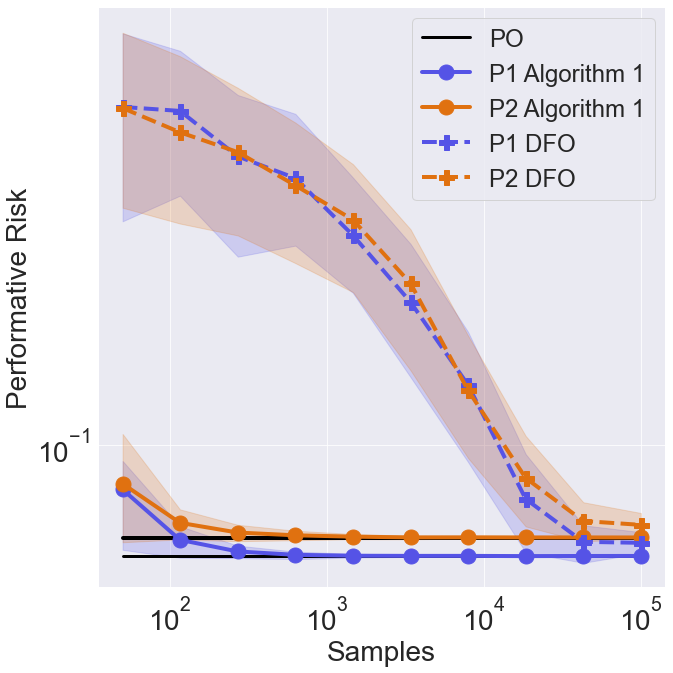

In [6]:
plt.rcParams['font.size'] = 28
plt.rcParams['axes.linewidth'] = 4
plt.figure(figsize=(10,10))

plt.loglog(num_rounds_lst, [PO_1 for i in num_rounds_lst],
           '-', color='k', label='PO', lw=3)
plt.loglog(num_rounds_lst, [PO_2 for i in num_rounds_lst],
           '-', color='k', lw=4)

plt.loglog(num_rounds_lst, np.nanmean(p3_risks,axis=0),
           '-', color='#5553E6', label='P1 Algorithm 1', lw=4, marker='o',markersize=15)
plt.fill_between(num_rounds_lst, np.sort(p3_risks,axis=0)[math.floor(N1*0.16)],
                 np.sort(p3_risks,axis=0)[-math.ceil(N1*0.16)],
                 alpha=0.2, color='#5553E6')
plt.loglog(num_rounds_lst, np.nanmean(p4_risks,axis=0),
           '-', color='#E07110', label='P2 Algorithm 1', lw=4, marker='o',markersize=15)
plt.fill_between(num_rounds_lst, np.sort(p4_risks,axis=0)[math.floor(N1*0.16)],
                 np.sort(p4_risks,axis=0)[-math.ceil(N1*0.16)],
                 alpha=0.2, color='#E07110')

plt.loglog(num_rounds_lst, np.nanmean(p1_risks,axis=0),
           '--', color='#5553E6', label='P1 DFO', lw=4, marker='P',markersize=15)
plt.fill_between(num_rounds_lst, np.sort(p1_risks,axis=0)[math.floor(N1*0.16)],
                 np.sort(p1_risks,axis=0)[-math.ceil(N1*0.16)],
                 alpha=0.2, color='#5553E6')
plt.loglog(num_rounds_lst, np.nanmean(p2_risks,axis=0),
           '--', color='#E07110', label='P2 DFO', lw=4, marker='P',markersize=15)
plt.fill_between(num_rounds_lst, np.sort(p2_risks,axis=0)[math.floor(N1*0.16)],
                 np.sort(p2_risks,axis=0)[-math.ceil(N1*0.16)],
                 alpha=0.2, color='#E07110')

plt.ylabel("Performative Risk")
plt.xlabel("Samples")
plt.legend(loc='upper right',fontsize=24)
plt.tight_layout()
plt.savefig('../figures/dfo_vs_2stage_convergence.png', dpi=300, format='png')
plt.show()